# Example: Setting up a Jansen-Rit-like cortical microcircuit using the Montbrio population model

In this example, we will use PyRates to build a new model of a cortical microcircuit, fusing the architecture of the Jansen-Rit model and the evolution equations for the population dynamics proposed by Montbrio and colleagues. 

As a reminder, Montbrio and colleagues derived a set of two coupled ODEs describing the dynamics of the average firing rate $r$ and membrane potential $v$ of a population of globally coupled quadratic integrate-and-fire neurons. The evolution equations are given by:

$$\tau \dot r = \frac{\Delta}{\pi\tau} +2 r v$$
$$\tau \dot v = v^2 +\eta + I(t) + J r \tau - (\pi r \tau)^2$$

With $\tau$ being the evolution time constant,  $J$ is the global coupling strength, $I(t)$ is external current and $\eta$ and $\Delta$ are the average and FWHM of the background input, respectively.

While the Jansen-Rit architecture is characterized by the following features:
- 3 interconnected populations: Pyramidal cells, excitatory interneurons and inhibitory interneurons
- Synaptic dynamics are expressed by alpha kernels (exponential rise and decay of the synaptic response) and differ between excitatory and inhibitors synapses

## Step I: Implementing the Montbrio population dynamics in PyRates

First, we set up operators implementing the equations from above. Thereby, we distinguish between excitatory and inhibitory populations.

In [9]:
import numpy as np
from pyrates.frontend import OperatorTemplate

exc = ['d/dt * r = (delta/(PI*tau) + 2.*r*v) /tau',
       'd/dt * v = (v^2 + eta + I_ext + (J*r+r_exc-r_inh)*tau - (PI*r*tau)^2) /tau']
inh = ['d/dt * r = (delta/(PI*tau) + 2.*r*v) / tau',
       'd/dt * v = (v^2 + eta + I_ext + (r_exc-r_inh-J*r)*tau - (PI*r*tau)^2) /tau']
variables = {'delta': {'default': 1.0},
             'tau': {'default': 1.0},
             'eta': {'default': -5.0},
             'J': {'default': 15.0},
             'r': {'default': 'output'},
             'v': {'default': 'variable'},
             'I_ext': {'default': 'input'},
             'r_exc': {'default': 'input'},
             'r_inh': {'default': 'input'}}

op_exc = OperatorTemplate(name='Op_exc', path=None, equations=exc, variables=variables)
op_inh = OperatorTemplate(name='Op_inh', path=None, equations=inh, variables=variables)

Next, we create a circuit with a single node representing an excitatory QIF population governed by the above defined excitatory population operator.

In [10]:
from pyrates.frontend import NodeTemplate, CircuitTemplate

node_exc_template = NodeTemplate(name='Pop_exc', path=None, operators=[op_exc])
pop_exc_template = CircuitTemplate(name='EC', path=None, nodes={'Pop_exc': node_exc_template})
pop_exc_ir = pop_exc_template.apply()

Now, we test whether the circuit behaves as expected, by simulating its behavior given a transient input.

In [11]:
from pyrates.backend import ComputeGraph

dt = 1e-3                                      # integration step size in s
dts = 1e-2                                     # variable storage sub-sampling step size in s
T = 42.                                        # total simulation time in s
inp = np.zeros((int(T/dt), 1))                 # external input to the population
inp[int(6./dt):int((T-12.)/dt)] = 3.

pop_exc = ComputeGraph(pop_exc_ir, vectorization="none", dt=dt, backend='numpy',
                       name='pop_exc', build_in_place=False)

result, _, _ = pop_exc.run(simulation_time=T, 
                           inputs={("Pop_exc.0", "Op_exc.0", "I_ext"): inp},
                           outputs={"r": ("Pop_exc.0", "Op_exc.0", "r"), 
                                    "v": ("Pop_exc.0", "Op_exc.0", "v")},
                           sampling_step_size=dts, profile='t')

Preparing simulation...
Running simulation...
42.0s of backend behavior were simulated in 2.8764703273773193 s given a simulation resolution of 0.001 s.


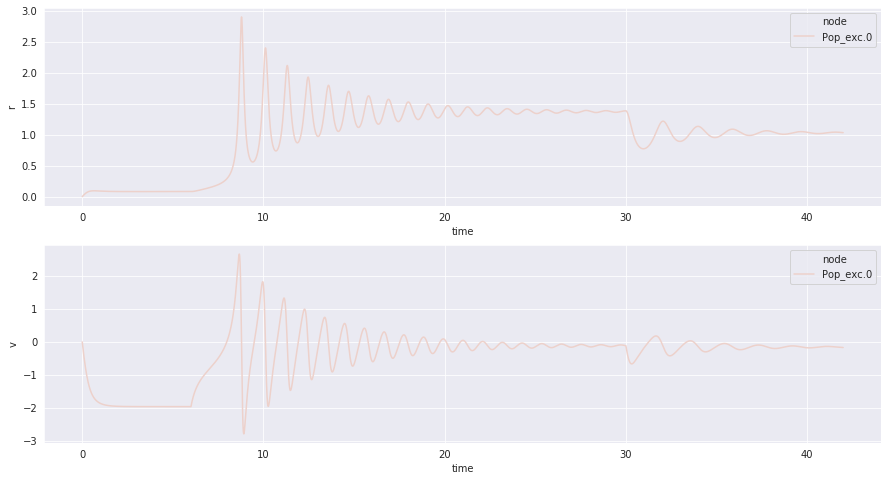

In [12]:
%matplotlib inline
import matplotlib.pyplot as plt
from pyrates.utility import plot_timeseries

fig, axes = plt.subplots(nrows=2, figsize=(15, 8))
plot_timeseries(result['r'], ax=axes[0], ylabel='r')
plot_timeseries(result['v'], ax=axes[1], ylabel='v')

## Step II: Creating a circuit of 3 interconnected QIF populations

In this step, we will create 3 populations like the one above and choose their parameters such that they represent a pyramidal cell, excitatory interneuron and inhibitor interneuron population. We will connect them to a Jansen-Rit like circuit and perform an initial study of the circuits dependence on the connection strength scaling.

In [13]:
pc = NodeTemplate(name='PC', path=None, operators={op_exc: {'J': 0.0, 'eta': -2.5}})
ein = NodeTemplate(name='EIN', path=None, operators={op_exc: {'J': 0.0, 'eta': -0.5}})
iin = NodeTemplate(name='IIN', path=None, operators={op_inh: {'tau': 2.0, 'J': 0.0, 'eta': -0.5}})

eic_ir = CircuitTemplate(name='eic_template', path=None,
                         nodes={'PC': pc, 'EIN': ein, 'IIN': iin}).apply()
eic_ir.add_edges_from([('PC/Op_exc/r', 'EIN/Op_exc/r_exc', {'weight': 13.5}),
                       ('EIN/Op_exc/r', 'PC/Op_exc/r_exc', {'weight': 0.8*13.5}),
                       ('PC/Op_exc/r', 'IIN/Op_inh/r_exc', {'weight': 0.25*13.5}),
                       ('IIN/Op_inh/r', 'PC/Op_exc/r_inh', {'weight': 1.75*13.5})])
eic = ComputeGraph(eic_ir, vectorization="nodes", dt=dt, backend='numpy',
                   name='EIC', build_in_place=False)

Preparing simulation...
Running simulation...


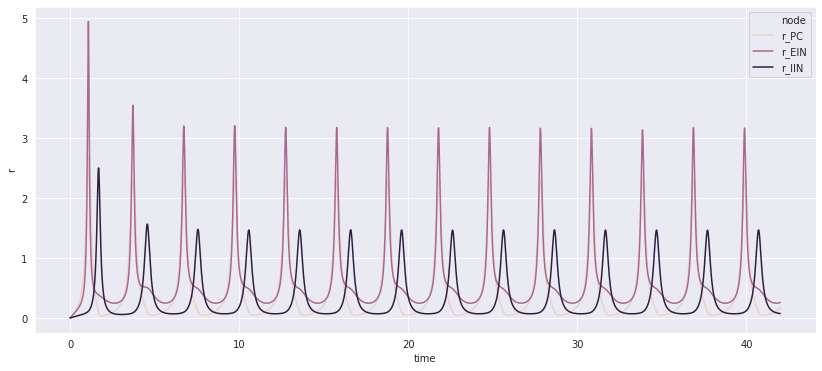

In [14]:
ext_input = np.random.uniform(3., 5., (int(T/dt), 1))
results = eic.run(simulation_time = T, 
                  outputs={'r_PC': ('PC.0', 'Op_exc.1', 'r'), 
                           'r_EIN': ('EIN.0', 'Op_exc.2', 'r'), 
                           'r_IIN': ('IIN.0', 'Op_inh.1', 'r')}, 
                  inputs={('PC.0', 'Op_exc.1', 'I_ext'): ext_input})

fig, axes = plt.subplots(figsize=(14, 6))
plot_timeseries(results, ax=axes, ylabel='r')

## Step III: Adding synaptic dynamics to the circuit

Now, we will finalize the cortical circuit model by adding a description of the synaptic response dynamics to each connection in the circuit. To this end, we will stick to the synaptic description of the Jansen-Rit model, but we will use a single synaptic response kernel for every synapse. The evolution of the synaptic current $I_{syn}$ is given by:

$$\tau_{syn} \dot{I_{syn}} = x$$
$$\tau_{syn} \dot{x} = \sum_n r_n - 2x - I_{syn}$$

with $\tau_{syn}$ being the time-scale of the synapse. We will now re-build the operators describing the population dynamics to include these synaptic dynamics.

In [15]:
exc_syn = ['d/dt * r = (delta/(PI*tau) + 2.*r*v) /tau',
           'd/dt * v = (v^2 + eta + I_ext + (I_exc - I_inh)*tau - (PI*r*tau)^2) /tau',
           'd/dt * I_exc = J*r + r_exc - I_exc/tau_exc',
           'd/dt * I_inh =  r_inh - I_inh/tau_inh'
          ]
inh_syn = ['d/dt * r = (delta/(PI*tau) + 2.*r*v) /tau',
           'd/dt * v = (v^2 + eta + I_ext + (I_exc - I_inh)*tau - (PI*r*tau)^2) /tau',
           'd/dt * I_exc = r_exc - I_exc/tau_exc',
           'd/dt * I_inh = J*r + r_inh - I_inh/tau_inh'
          ]
variables = {'delta': {'default': 1.0},
             'tau': {'default': 1.0},
             'eta': {'default': -2.5},
             'J': {'default': 0.0},
             'tau_exc': {'default': 1.0},
             'tau_inh': {'default': 2.0},
             'r': {'default': 'output'},
             'v': {'default': 'variable'},
             'I_exc': {'default': 'variable'},
             'I_inh': {'default': 'variable'},
             'I_ext': {'default': 'input'},
             'r_exc': {'default': 'input'},
             'r_inh': {'default': 'input'},
             }

op_exc_syn = OperatorTemplate(name='Op_exc_syn', path=None, equations=exc_syn, variables=variables)
op_inh_syn = OperatorTemplate(name='Op_inh_syn', path=None, equations=inh_syn, variables=variables)

And now, we rebuild the circuit.

In [16]:
pcs = NodeTemplate(name='PCs', path=None, operators=[op_exc_syn])
eins = NodeTemplate(name='EINs', path=None, operators={op_exc_syn: {'eta': -0.5}})
iins = NodeTemplate(name='IINs', path=None, operators={op_inh_syn: {'tau': 2.0, 'eta': -0.5}})

jrc_template = CircuitTemplate(name='jrc_template', path=None,
                               nodes={'PCs': pcs, 'EINs': eins, 'IINs': iins},
                               edges=[('PCs/Op_exc_syn/r', 'EINs/Op_exc_syn/r_exc', 
                                       None, {'weight': 13.5}),
                                      ('EINs/Op_exc_syn/r', 'PCs/Op_exc_syn/r_exc',
                                       None, {'weight': 0.8*13.5}),
                                      ('PCs/Op_exc_syn/r', 'IINs/Op_inh_syn/r_exc', 
                                       None, {'weight': 0.25*13.5}),
                                      ('IINs/Op_inh_syn/r', 'PCs/Op_exc_syn/r_inh', 
                                       None, {'weight': 1.75*13.5})]
                               )
jrc_ir = jrc_template.apply()
jrc = ComputeGraph(jrc_ir, vectorization="nodes", dt=dt, backend='numpy',
                   name='JRC', build_in_place=False)

Preparing simulation...
Running simulation...


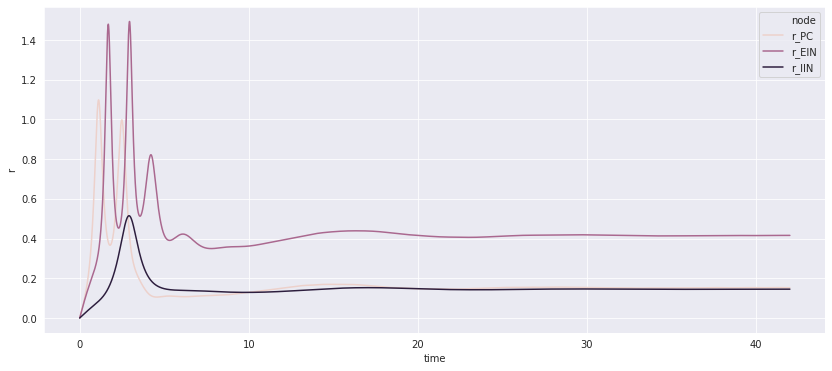

In [17]:
ext_input = np.random.uniform(3., 5., (int(T/dt), 1))
results = jrc.run(simulation_time = T, 
                  outputs={'r_PC': ('PCs.0', 'Op_exc_syn.0', 'r'), 
                           'r_EIN': ('EINs.0', 'Op_exc_syn.1', 'r'), 
                           'r_IIN': ('IINs.0', 'Op_inh_syn.1', 'r')}, 
                  inputs={('PCs.0', 'Op_exc_syn.0', 'I_ext'): ext_input})

fig, axes = plt.subplots(figsize=(14, 6))
plot_timeseries(results, ax=axes, ylabel='r')

## Step IV: Investigating the models parameter space

Now, we will perform some parameter sweeps to gain an intuition of how different parameters can affect the model dynamics. We will first investigate how the model response changes when the synaptic connection strength scaling $J$ is altered.

Preparing simulation...
Running simulation...


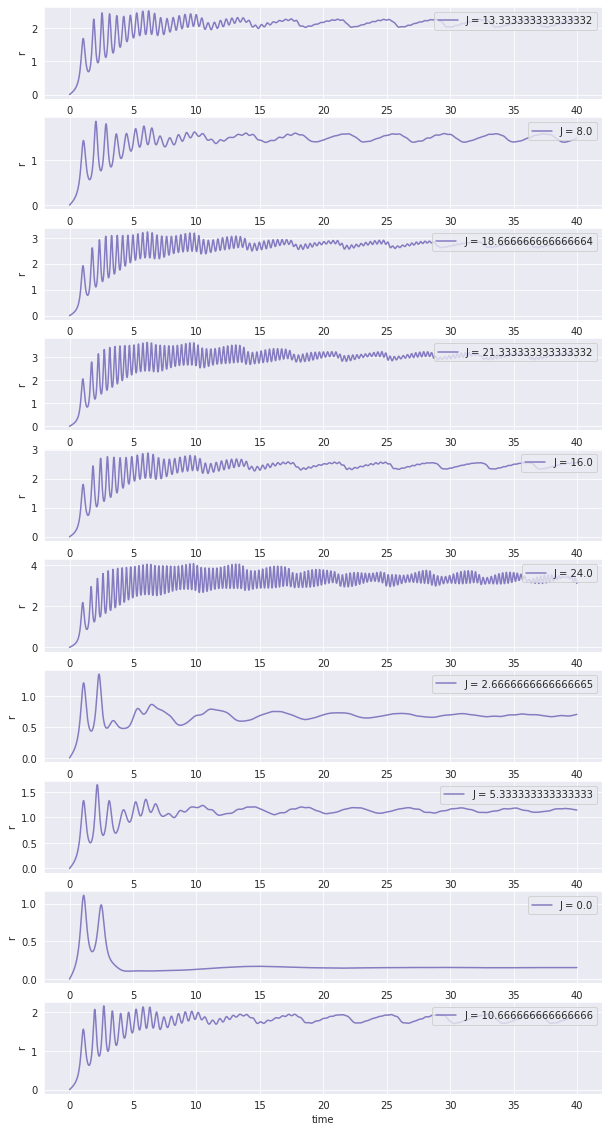

In [18]:
from pyrates.utility import grid_search, create_cmap, plot_timeseries
import matplotlib.pyplot as plt
from copy import deepcopy

Js = np.linspace(0, 24, 10)
T = 40.
dt = 1e-3
dts = 1e-2
ext_input = np.random.uniform(3., 5., (int(T/dt), 1))

results = grid_search(deepcopy(jrc_template), param_grid={'J': Js}, 
                      param_map={'J': {'var': [('Op_exc_syn.0', 'J'), 
                                               ('Op_exc_syn.1', 'J'),
                                               ('Op_inh_syn.1', 'J')],
                                       'nodes': ['PCs.0', 'EINs.0', 'IINs.0']}},
                      simulation_time=T, dt=dt, sampling_step_size=dts,
                      inputs={('PCs.0', 'Op_exc_syn.0', 'I_ext'): ext_input},
                      outputs={'r': ('PCs.0', 'Op_exc_syn.0', 'r')},
                      init_kwargs={'vectorization': 'nodes', 'build_in_place': False})

fig, axes = plt.subplots(nrows=len(Js), figsize=(10, 20))
cmap = create_cmap('pyrates_purple', as_cmap=False, n_colors=1, reverse=True)
for i, ax in enumerate(axes):
    plot_timeseries(results.iloc[:, i], ax=ax, cmap=cmap, ylabel='r')
    ax.legend([f'J = {results.columns.values[i][0]}'], loc='upper right')

In [19]:
w_ein_pc = np.linspace(0.5, 2, 10) * 0.8*13.5
w_iin_pc = np.linspace(0.5, 2, 10) * 1.75*13.5

T = 100.
dt = 1e-3
dts = 1e-2
ext_input = np.random.uniform(3., 5., (int(T/dt), 1))

results = grid_search(deepcopy(jrc_template), 
                      param_grid={'w_ep': w_ein_pc, 'w_ip': w_iin_pc}, 
                      param_map={'w_ep': {'var': [(None, 'weight')],
                                          'edges': [('EINs.0', 'PCs.0', 0)]},
                                 'w_ip': {'var': [(None, 'weight')],
                                          'edges': [('IINs.0', 'PCs.0', 0)]}},
                      simulation_time=T, dt=dt, sampling_step_size=dts,
                      inputs={('PCs.0', 'Op_exc_syn.0', 'I_ext'): ext_input},
                      outputs={'r': ('PCs.0', 'Op_exc_syn.0', 'r')},
                      init_kwargs={'vectorization': 'nodes', 'build_in_place': False},
                      permute_grid=True)

Preparing simulation...
Running simulation...


In [20]:
from pyrates.utility import plot_psd

# calculate power-spectral density of firing rate fluctuations
max_freq = np.zeros((len(w_ein_pc), len(w_iin_pc)))
max_pow = np.zeros_like(max_freq)
for we in w_ein_pc:
    for wi in w_iin_pc:
        plot_psd(results[we][wi], tmin=30.0, show=False)
        p = plt.gca().get_lines()[-1].get_ydata()
        f = plt.gca().get_lines()[-1].get_xdata()
        idx_r, idx_c = np.argwhere(w_ein_pc == we)[0], np.argwhere(w_iin_pc == wi)[0]
        max_idx = np.argmax(p)
        max_freq[idx_r, idx_c] = f[max_idx]
        max_pow[idx_r, idx_c] = p[max_idx]
        plt.close(plt.gcf())

Creating RawArray with float64 data, n_channels=1, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    99.990 secs
Ready.
Effective window size : 20.480 (s)
Need more than one channel to make topography for eeg. Disabling interactivity.


/home/rgast/Software/anaconda3/envs/pyrates_tutorial/lib/python3.6/site-packages/pyrates/utility/visualization.py:521: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  return plot_raw_psd(raw, tmin=tmin, fmin=fmin, fmax=fmax, **kwargs).axes


Creating RawArray with float64 data, n_channels=1, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    99.990 secs
Ready.
Effective window size : 20.480 (s)
Need more than one channel to make topography for eeg. Disabling interactivity.
Creating RawArray with float64 data, n_channels=1, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    99.990 secs
Ready.
Effective window size : 20.480 (s)
Need more than one channel to make topography for eeg. Disabling interactivity.


/home/rgast/Software/anaconda3/envs/pyrates_tutorial/lib/python3.6/site-packages/pyrates/utility/visualization.py:521: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  return plot_raw_psd(raw, tmin=tmin, fmin=fmin, fmax=fmax, **kwargs).axes
/home/rgast/Software/anaconda3/envs/pyrates_tutorial/lib/python3.6/site-packages/pyrates/utility/visualization.py:521: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  return plot_raw_psd(raw, tmin=tmin, fmin=fmin, fmax=fmax, **kwargs).axes


Creating RawArray with float64 data, n_channels=1, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    99.990 secs
Ready.
Effective window size : 20.480 (s)
Need more than one channel to make topography for eeg. Disabling interactivity.
Creating RawArray with float64 data, n_channels=1, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    99.990 secs
Ready.
Effective window size : 20.480 (s)
Need more than one channel to make topography for eeg. Disabling interactivity.


/home/rgast/Software/anaconda3/envs/pyrates_tutorial/lib/python3.6/site-packages/pyrates/utility/visualization.py:521: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  return plot_raw_psd(raw, tmin=tmin, fmin=fmin, fmax=fmax, **kwargs).axes
/home/rgast/Software/anaconda3/envs/pyrates_tutorial/lib/python3.6/site-packages/pyrates/utility/visualization.py:521: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  return plot_raw_psd(raw, tmin=tmin, fmin=fmin, fmax=fmax, **kwargs).axes


Creating RawArray with float64 data, n_channels=1, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    99.990 secs
Ready.
Effective window size : 20.480 (s)
Need more than one channel to make topography for eeg. Disabling interactivity.
Creating RawArray with float64 data, n_channels=1, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    99.990 secs
Ready.
Effective window size : 20.480 (s)
Need more than one channel to make topography for eeg. Disabling interactivity.


/home/rgast/Software/anaconda3/envs/pyrates_tutorial/lib/python3.6/site-packages/pyrates/utility/visualization.py:521: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  return plot_raw_psd(raw, tmin=tmin, fmin=fmin, fmax=fmax, **kwargs).axes
/home/rgast/Software/anaconda3/envs/pyrates_tutorial/lib/python3.6/site-packages/pyrates/utility/visualization.py:521: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  return plot_raw_psd(raw, tmin=tmin, fmin=fmin, fmax=fmax, **kwargs).axes


Creating RawArray with float64 data, n_channels=1, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    99.990 secs
Ready.
Effective window size : 20.480 (s)
Need more than one channel to make topography for eeg. Disabling interactivity.
Creating RawArray with float64 data, n_channels=1, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    99.990 secs
Ready.
Effective window size : 20.480 (s)
Need more than one channel to make topography for eeg. Disabling interactivity.


/home/rgast/Software/anaconda3/envs/pyrates_tutorial/lib/python3.6/site-packages/pyrates/utility/visualization.py:521: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  return plot_raw_psd(raw, tmin=tmin, fmin=fmin, fmax=fmax, **kwargs).axes
/home/rgast/Software/anaconda3/envs/pyrates_tutorial/lib/python3.6/site-packages/pyrates/utility/visualization.py:521: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  return plot_raw_psd(raw, tmin=tmin, fmin=fmin, fmax=fmax, **kwargs).axes


Creating RawArray with float64 data, n_channels=1, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    99.990 secs
Ready.
Effective window size : 20.480 (s)
Need more than one channel to make topography for eeg. Disabling interactivity.
Creating RawArray with float64 data, n_channels=1, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    99.990 secs
Ready.


/home/rgast/Software/anaconda3/envs/pyrates_tutorial/lib/python3.6/site-packages/pyrates/utility/visualization.py:521: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  return plot_raw_psd(raw, tmin=tmin, fmin=fmin, fmax=fmax, **kwargs).axes


Effective window size : 20.480 (s)
Need more than one channel to make topography for eeg. Disabling interactivity.
Creating RawArray with float64 data, n_channels=1, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    99.990 secs
Ready.
Effective window size : 20.480 (s)
Need more than one channel to make topography for eeg. Disabling interactivity.


/home/rgast/Software/anaconda3/envs/pyrates_tutorial/lib/python3.6/site-packages/pyrates/utility/visualization.py:521: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  return plot_raw_psd(raw, tmin=tmin, fmin=fmin, fmax=fmax, **kwargs).axes
/home/rgast/Software/anaconda3/envs/pyrates_tutorial/lib/python3.6/site-packages/pyrates/utility/visualization.py:521: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  return plot_raw_psd(raw, tmin=tmin, fmin=fmin, fmax=fmax, **kwargs).axes


Creating RawArray with float64 data, n_channels=1, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    99.990 secs
Ready.
Effective window size : 20.480 (s)
Need more than one channel to make topography for eeg. Disabling interactivity.
Creating RawArray with float64 data, n_channels=1, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    99.990 secs
Ready.
Effective window size : 20.480 (s)
Need more than one channel to make topography for eeg. Disabling interactivity.


/home/rgast/Software/anaconda3/envs/pyrates_tutorial/lib/python3.6/site-packages/pyrates/utility/visualization.py:521: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  return plot_raw_psd(raw, tmin=tmin, fmin=fmin, fmax=fmax, **kwargs).axes
/home/rgast/Software/anaconda3/envs/pyrates_tutorial/lib/python3.6/site-packages/pyrates/utility/visualization.py:521: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  return plot_raw_psd(raw, tmin=tmin, fmin=fmin, fmax=fmax, **kwargs).axes


Creating RawArray with float64 data, n_channels=1, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    99.990 secs
Ready.
Effective window size : 20.480 (s)
Need more than one channel to make topography for eeg. Disabling interactivity.
Creating RawArray with float64 data, n_channels=1, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    99.990 secs
Ready.
Effective window size : 20.480 (s)
Need more than one channel to make topography for eeg. Disabling interactivity.


/home/rgast/Software/anaconda3/envs/pyrates_tutorial/lib/python3.6/site-packages/pyrates/utility/visualization.py:521: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  return plot_raw_psd(raw, tmin=tmin, fmin=fmin, fmax=fmax, **kwargs).axes
/home/rgast/Software/anaconda3/envs/pyrates_tutorial/lib/python3.6/site-packages/pyrates/utility/visualization.py:521: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  return plot_raw_psd(raw, tmin=tmin, fmin=fmin, fmax=fmax, **kwargs).axes


Creating RawArray with float64 data, n_channels=1, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    99.990 secs
Ready.
Effective window size : 20.480 (s)
Need more than one channel to make topography for eeg. Disabling interactivity.
Creating RawArray with float64 data, n_channels=1, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    99.990 secs
Ready.
Effective window size : 20.480 (s)
Need more than one channel to make topography for eeg. Disabling interactivity.


/home/rgast/Software/anaconda3/envs/pyrates_tutorial/lib/python3.6/site-packages/pyrates/utility/visualization.py:521: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  return plot_raw_psd(raw, tmin=tmin, fmin=fmin, fmax=fmax, **kwargs).axes
/home/rgast/Software/anaconda3/envs/pyrates_tutorial/lib/python3.6/site-packages/pyrates/utility/visualization.py:521: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  return plot_raw_psd(raw, tmin=tmin, fmin=fmin, fmax=fmax, **kwargs).axes


Creating RawArray with float64 data, n_channels=1, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    99.990 secs
Ready.
Effective window size : 20.480 (s)
Need more than one channel to make topography for eeg. Disabling interactivity.
Creating RawArray with float64 data, n_channels=1, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    99.990 secs
Ready.
Effective window size : 20.480 (s)
Need more than one channel to make topography for eeg. Disabling interactivity.


/home/rgast/Software/anaconda3/envs/pyrates_tutorial/lib/python3.6/site-packages/pyrates/utility/visualization.py:521: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  return plot_raw_psd(raw, tmin=tmin, fmin=fmin, fmax=fmax, **kwargs).axes
/home/rgast/Software/anaconda3/envs/pyrates_tutorial/lib/python3.6/site-packages/pyrates/utility/visualization.py:521: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  return plot_raw_psd(raw, tmin=tmin, fmin=fmin, fmax=fmax, **kwargs).axes


Creating RawArray with float64 data, n_channels=1, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    99.990 secs
Ready.
Effective window size : 20.480 (s)
Need more than one channel to make topography for eeg. Disabling interactivity.
Creating RawArray with float64 data, n_channels=1, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    99.990 secs
Ready.
Effective window size : 20.480 (s)
Need more than one channel to make topography for eeg. Disabling interactivity.


/home/rgast/Software/anaconda3/envs/pyrates_tutorial/lib/python3.6/site-packages/pyrates/utility/visualization.py:521: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  return plot_raw_psd(raw, tmin=tmin, fmin=fmin, fmax=fmax, **kwargs).axes
/home/rgast/Software/anaconda3/envs/pyrates_tutorial/lib/python3.6/site-packages/pyrates/utility/visualization.py:521: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  return plot_raw_psd(raw, tmin=tmin, fmin=fmin, fmax=fmax, **kwargs).axes


Creating RawArray with float64 data, n_channels=1, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    99.990 secs
Ready.
Effective window size : 20.480 (s)
Need more than one channel to make topography for eeg. Disabling interactivity.
Creating RawArray with float64 data, n_channels=1, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    99.990 secs
Ready.
Effective window size : 20.480 (s)
Need more than one channel to make topography for eeg. Disabling interactivity.


/home/rgast/Software/anaconda3/envs/pyrates_tutorial/lib/python3.6/site-packages/pyrates/utility/visualization.py:521: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  return plot_raw_psd(raw, tmin=tmin, fmin=fmin, fmax=fmax, **kwargs).axes
/home/rgast/Software/anaconda3/envs/pyrates_tutorial/lib/python3.6/site-packages/pyrates/utility/visualization.py:521: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  return plot_raw_psd(raw, tmin=tmin, fmin=fmin, fmax=fmax, **kwargs).axes


Creating RawArray with float64 data, n_channels=1, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    99.990 secs
Ready.
Effective window size : 20.480 (s)
Need more than one channel to make topography for eeg. Disabling interactivity.
Creating RawArray with float64 data, n_channels=1, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    99.990 secs
Ready.
Effective window size : 20.480 (s)
Need more than one channel to make topography for eeg. Disabling interactivity.


/home/rgast/Software/anaconda3/envs/pyrates_tutorial/lib/python3.6/site-packages/pyrates/utility/visualization.py:521: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  return plot_raw_psd(raw, tmin=tmin, fmin=fmin, fmax=fmax, **kwargs).axes
/home/rgast/Software/anaconda3/envs/pyrates_tutorial/lib/python3.6/site-packages/pyrates/utility/visualization.py:521: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  return plot_raw_psd(raw, tmin=tmin, fmin=fmin, fmax=fmax, **kwargs).axes


Creating RawArray with float64 data, n_channels=1, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    99.990 secs
Ready.
Effective window size : 20.480 (s)
Need more than one channel to make topography for eeg. Disabling interactivity.
Creating RawArray with float64 data, n_channels=1, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    99.990 secs
Ready.
Effective window size : 20.480 (s)
Need more than one channel to make topography for eeg. Disabling interactivity.


/home/rgast/Software/anaconda3/envs/pyrates_tutorial/lib/python3.6/site-packages/pyrates/utility/visualization.py:521: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  return plot_raw_psd(raw, tmin=tmin, fmin=fmin, fmax=fmax, **kwargs).axes
/home/rgast/Software/anaconda3/envs/pyrates_tutorial/lib/python3.6/site-packages/pyrates/utility/visualization.py:521: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  return plot_raw_psd(raw, tmin=tmin, fmin=fmin, fmax=fmax, **kwargs).axes


Creating RawArray with float64 data, n_channels=1, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    99.990 secs
Ready.
Effective window size : 20.480 (s)
Need more than one channel to make topography for eeg. Disabling interactivity.
Creating RawArray with float64 data, n_channels=1, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    99.990 secs
Ready.
Effective window size : 20.480 (s)
Need more than one channel to make topography for eeg. Disabling interactivity.


/home/rgast/Software/anaconda3/envs/pyrates_tutorial/lib/python3.6/site-packages/pyrates/utility/visualization.py:521: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  return plot_raw_psd(raw, tmin=tmin, fmin=fmin, fmax=fmax, **kwargs).axes
/home/rgast/Software/anaconda3/envs/pyrates_tutorial/lib/python3.6/site-packages/pyrates/utility/visualization.py:521: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  return plot_raw_psd(raw, tmin=tmin, fmin=fmin, fmax=fmax, **kwargs).axes


Creating RawArray with float64 data, n_channels=1, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    99.990 secs
Ready.
Effective window size : 20.480 (s)
Need more than one channel to make topography for eeg. Disabling interactivity.
Creating RawArray with float64 data, n_channels=1, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    99.990 secs
Ready.
Effective window size : 20.480 (s)
Need more than one channel to make topography for eeg. Disabling interactivity.


/home/rgast/Software/anaconda3/envs/pyrates_tutorial/lib/python3.6/site-packages/pyrates/utility/visualization.py:521: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  return plot_raw_psd(raw, tmin=tmin, fmin=fmin, fmax=fmax, **kwargs).axes
/home/rgast/Software/anaconda3/envs/pyrates_tutorial/lib/python3.6/site-packages/pyrates/utility/visualization.py:521: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  return plot_raw_psd(raw, tmin=tmin, fmin=fmin, fmax=fmax, **kwargs).axes


Creating RawArray with float64 data, n_channels=1, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    99.990 secs
Ready.
Effective window size : 20.480 (s)
Need more than one channel to make topography for eeg. Disabling interactivity.
Creating RawArray with float64 data, n_channels=1, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    99.990 secs
Ready.
Effective window size : 20.480 (s)
Need more than one channel to make topography for eeg. Disabling interactivity.


/home/rgast/Software/anaconda3/envs/pyrates_tutorial/lib/python3.6/site-packages/pyrates/utility/visualization.py:521: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  return plot_raw_psd(raw, tmin=tmin, fmin=fmin, fmax=fmax, **kwargs).axes
/home/rgast/Software/anaconda3/envs/pyrates_tutorial/lib/python3.6/site-packages/pyrates/utility/visualization.py:521: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  return plot_raw_psd(raw, tmin=tmin, fmin=fmin, fmax=fmax, **kwargs).axes


Creating RawArray with float64 data, n_channels=1, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    99.990 secs
Ready.
Effective window size : 20.480 (s)
Need more than one channel to make topography for eeg. Disabling interactivity.
Creating RawArray with float64 data, n_channels=1, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    99.990 secs
Ready.
Effective window size : 20.480 (s)
Need more than one channel to make topography for eeg. Disabling interactivity.


/home/rgast/Software/anaconda3/envs/pyrates_tutorial/lib/python3.6/site-packages/pyrates/utility/visualization.py:521: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  return plot_raw_psd(raw, tmin=tmin, fmin=fmin, fmax=fmax, **kwargs).axes
/home/rgast/Software/anaconda3/envs/pyrates_tutorial/lib/python3.6/site-packages/pyrates/utility/visualization.py:521: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  return plot_raw_psd(raw, tmin=tmin, fmin=fmin, fmax=fmax, **kwargs).axes


Creating RawArray with float64 data, n_channels=1, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    99.990 secs
Ready.
Effective window size : 20.480 (s)
Need more than one channel to make topography for eeg. Disabling interactivity.
Creating RawArray with float64 data, n_channels=1, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    99.990 secs
Ready.
Effective window size : 20.480 (s)
Need more than one channel to make topography for eeg. Disabling interactivity.


/home/rgast/Software/anaconda3/envs/pyrates_tutorial/lib/python3.6/site-packages/pyrates/utility/visualization.py:521: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  return plot_raw_psd(raw, tmin=tmin, fmin=fmin, fmax=fmax, **kwargs).axes
/home/rgast/Software/anaconda3/envs/pyrates_tutorial/lib/python3.6/site-packages/pyrates/utility/visualization.py:521: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  return plot_raw_psd(raw, tmin=tmin, fmin=fmin, fmax=fmax, **kwargs).axes


Creating RawArray with float64 data, n_channels=1, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    99.990 secs
Ready.
Effective window size : 20.480 (s)
Need more than one channel to make topography for eeg. Disabling interactivity.
Creating RawArray with float64 data, n_channels=1, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    99.990 secs
Ready.
Effective window size : 20.480 (s)
Need more than one channel to make topography for eeg. Disabling interactivity.


/home/rgast/Software/anaconda3/envs/pyrates_tutorial/lib/python3.6/site-packages/pyrates/utility/visualization.py:521: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  return plot_raw_psd(raw, tmin=tmin, fmin=fmin, fmax=fmax, **kwargs).axes
/home/rgast/Software/anaconda3/envs/pyrates_tutorial/lib/python3.6/site-packages/pyrates/utility/visualization.py:521: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  return plot_raw_psd(raw, tmin=tmin, fmin=fmin, fmax=fmax, **kwargs).axes


Creating RawArray with float64 data, n_channels=1, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    99.990 secs
Ready.
Effective window size : 20.480 (s)
Need more than one channel to make topography for eeg. Disabling interactivity.
Creating RawArray with float64 data, n_channels=1, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    99.990 secs
Ready.


/home/rgast/Software/anaconda3/envs/pyrates_tutorial/lib/python3.6/site-packages/pyrates/utility/visualization.py:521: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  return plot_raw_psd(raw, tmin=tmin, fmin=fmin, fmax=fmax, **kwargs).axes


Effective window size : 20.480 (s)
Need more than one channel to make topography for eeg. Disabling interactivity.
Creating RawArray with float64 data, n_channels=1, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    99.990 secs
Ready.
Effective window size : 20.480 (s)
Need more than one channel to make topography for eeg. Disabling interactivity.


/home/rgast/Software/anaconda3/envs/pyrates_tutorial/lib/python3.6/site-packages/pyrates/utility/visualization.py:521: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  return plot_raw_psd(raw, tmin=tmin, fmin=fmin, fmax=fmax, **kwargs).axes
/home/rgast/Software/anaconda3/envs/pyrates_tutorial/lib/python3.6/site-packages/pyrates/utility/visualization.py:521: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  return plot_raw_psd(raw, tmin=tmin, fmin=fmin, fmax=fmax, **kwargs).axes


Creating RawArray with float64 data, n_channels=1, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    99.990 secs
Ready.
Effective window size : 20.480 (s)
Need more than one channel to make topography for eeg. Disabling interactivity.
Creating RawArray with float64 data, n_channels=1, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    99.990 secs
Ready.
Effective window size : 20.480 (s)
Need more than one channel to make topography for eeg. Disabling interactivity.


/home/rgast/Software/anaconda3/envs/pyrates_tutorial/lib/python3.6/site-packages/pyrates/utility/visualization.py:521: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  return plot_raw_psd(raw, tmin=tmin, fmin=fmin, fmax=fmax, **kwargs).axes
/home/rgast/Software/anaconda3/envs/pyrates_tutorial/lib/python3.6/site-packages/pyrates/utility/visualization.py:521: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  return plot_raw_psd(raw, tmin=tmin, fmin=fmin, fmax=fmax, **kwargs).axes


Creating RawArray with float64 data, n_channels=1, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    99.990 secs
Ready.
Effective window size : 20.480 (s)
Need more than one channel to make topography for eeg. Disabling interactivity.
Creating RawArray with float64 data, n_channels=1, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    99.990 secs
Ready.
Effective window size : 20.480 (s)
Need more than one channel to make topography for eeg. Disabling interactivity.


/home/rgast/Software/anaconda3/envs/pyrates_tutorial/lib/python3.6/site-packages/pyrates/utility/visualization.py:521: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  return plot_raw_psd(raw, tmin=tmin, fmin=fmin, fmax=fmax, **kwargs).axes
/home/rgast/Software/anaconda3/envs/pyrates_tutorial/lib/python3.6/site-packages/pyrates/utility/visualization.py:521: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  return plot_raw_psd(raw, tmin=tmin, fmin=fmin, fmax=fmax, **kwargs).axes


Creating RawArray with float64 data, n_channels=1, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    99.990 secs
Ready.
Effective window size : 20.480 (s)
Need more than one channel to make topography for eeg. Disabling interactivity.
Creating RawArray with float64 data, n_channels=1, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    99.990 secs
Ready.
Effective window size : 20.480 (s)
Need more than one channel to make topography for eeg. Disabling interactivity.


/home/rgast/Software/anaconda3/envs/pyrates_tutorial/lib/python3.6/site-packages/pyrates/utility/visualization.py:521: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  return plot_raw_psd(raw, tmin=tmin, fmin=fmin, fmax=fmax, **kwargs).axes
/home/rgast/Software/anaconda3/envs/pyrates_tutorial/lib/python3.6/site-packages/pyrates/utility/visualization.py:521: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  return plot_raw_psd(raw, tmin=tmin, fmin=fmin, fmax=fmax, **kwargs).axes


Creating RawArray with float64 data, n_channels=1, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    99.990 secs
Ready.
Effective window size : 20.480 (s)
Need more than one channel to make topography for eeg. Disabling interactivity.
Creating RawArray with float64 data, n_channels=1, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    99.990 secs
Ready.
Effective window size : 20.480 (s)
Need more than one channel to make topography for eeg. Disabling interactivity.


/home/rgast/Software/anaconda3/envs/pyrates_tutorial/lib/python3.6/site-packages/pyrates/utility/visualization.py:521: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  return plot_raw_psd(raw, tmin=tmin, fmin=fmin, fmax=fmax, **kwargs).axes
/home/rgast/Software/anaconda3/envs/pyrates_tutorial/lib/python3.6/site-packages/pyrates/utility/visualization.py:521: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  return plot_raw_psd(raw, tmin=tmin, fmin=fmin, fmax=fmax, **kwargs).axes


Creating RawArray with float64 data, n_channels=1, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    99.990 secs
Ready.
Effective window size : 20.480 (s)
Need more than one channel to make topography for eeg. Disabling interactivity.


/home/rgast/Software/anaconda3/envs/pyrates_tutorial/lib/python3.6/site-packages/pyrates/utility/visualization.py:521: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  return plot_raw_psd(raw, tmin=tmin, fmin=fmin, fmax=fmax, **kwargs).axes


Creating RawArray with float64 data, n_channels=1, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    99.990 secs
Ready.
Effective window size : 20.480 (s)
Need more than one channel to make topography for eeg. Disabling interactivity.
Creating RawArray with float64 data, n_channels=1, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    99.990 secs
Ready.
Effective window size : 20.480 (s)
Need more than one channel to make topography for eeg. Disabling interactivity.


/home/rgast/Software/anaconda3/envs/pyrates_tutorial/lib/python3.6/site-packages/pyrates/utility/visualization.py:521: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  return plot_raw_psd(raw, tmin=tmin, fmin=fmin, fmax=fmax, **kwargs).axes
/home/rgast/Software/anaconda3/envs/pyrates_tutorial/lib/python3.6/site-packages/pyrates/utility/visualization.py:521: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  return plot_raw_psd(raw, tmin=tmin, fmin=fmin, fmax=fmax, **kwargs).axes


Creating RawArray with float64 data, n_channels=1, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    99.990 secs
Ready.
Effective window size : 20.480 (s)
Need more than one channel to make topography for eeg. Disabling interactivity.
Creating RawArray with float64 data, n_channels=1, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    99.990 secs
Ready.


/home/rgast/Software/anaconda3/envs/pyrates_tutorial/lib/python3.6/site-packages/pyrates/utility/visualization.py:521: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  return plot_raw_psd(raw, tmin=tmin, fmin=fmin, fmax=fmax, **kwargs).axes


Effective window size : 20.480 (s)
Need more than one channel to make topography for eeg. Disabling interactivity.
Creating RawArray with float64 data, n_channels=1, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    99.990 secs
Ready.
Effective window size : 20.480 (s)
Need more than one channel to make topography for eeg. Disabling interactivity.


/home/rgast/Software/anaconda3/envs/pyrates_tutorial/lib/python3.6/site-packages/pyrates/utility/visualization.py:521: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  return plot_raw_psd(raw, tmin=tmin, fmin=fmin, fmax=fmax, **kwargs).axes
/home/rgast/Software/anaconda3/envs/pyrates_tutorial/lib/python3.6/site-packages/pyrates/utility/visualization.py:521: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  return plot_raw_psd(raw, tmin=tmin, fmin=fmin, fmax=fmax, **kwargs).axes


Creating RawArray with float64 data, n_channels=1, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    99.990 secs
Ready.
Effective window size : 20.480 (s)
Need more than one channel to make topography for eeg. Disabling interactivity.
Creating RawArray with float64 data, n_channels=1, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    99.990 secs
Ready.
Effective window size : 20.480 (s)
Need more than one channel to make topography for eeg. Disabling interactivity.


/home/rgast/Software/anaconda3/envs/pyrates_tutorial/lib/python3.6/site-packages/pyrates/utility/visualization.py:521: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  return plot_raw_psd(raw, tmin=tmin, fmin=fmin, fmax=fmax, **kwargs).axes
/home/rgast/Software/anaconda3/envs/pyrates_tutorial/lib/python3.6/site-packages/pyrates/utility/visualization.py:521: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  return plot_raw_psd(raw, tmin=tmin, fmin=fmin, fmax=fmax, **kwargs).axes


Creating RawArray with float64 data, n_channels=1, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    99.990 secs
Ready.
Effective window size : 20.480 (s)
Need more than one channel to make topography for eeg. Disabling interactivity.
Creating RawArray with float64 data, n_channels=1, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    99.990 secs
Ready.
Effective window size : 20.480 (s)
Need more than one channel to make topography for eeg. Disabling interactivity.


/home/rgast/Software/anaconda3/envs/pyrates_tutorial/lib/python3.6/site-packages/pyrates/utility/visualization.py:521: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  return plot_raw_psd(raw, tmin=tmin, fmin=fmin, fmax=fmax, **kwargs).axes
/home/rgast/Software/anaconda3/envs/pyrates_tutorial/lib/python3.6/site-packages/pyrates/utility/visualization.py:521: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  return plot_raw_psd(raw, tmin=tmin, fmin=fmin, fmax=fmax, **kwargs).axes


Creating RawArray with float64 data, n_channels=1, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    99.990 secs
Ready.
Effective window size : 20.480 (s)
Need more than one channel to make topography for eeg. Disabling interactivity.
Creating RawArray with float64 data, n_channels=1, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    99.990 secs
Ready.
Effective window size : 20.480 (s)
Need more than one channel to make topography for eeg. Disabling interactivity.


/home/rgast/Software/anaconda3/envs/pyrates_tutorial/lib/python3.6/site-packages/pyrates/utility/visualization.py:521: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  return plot_raw_psd(raw, tmin=tmin, fmin=fmin, fmax=fmax, **kwargs).axes
/home/rgast/Software/anaconda3/envs/pyrates_tutorial/lib/python3.6/site-packages/pyrates/utility/visualization.py:521: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  return plot_raw_psd(raw, tmin=tmin, fmin=fmin, fmax=fmax, **kwargs).axes


Creating RawArray with float64 data, n_channels=1, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    99.990 secs
Ready.
Effective window size : 20.480 (s)
Need more than one channel to make topography for eeg. Disabling interactivity.
Creating RawArray with float64 data, n_channels=1, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    99.990 secs
Ready.
Effective window size : 20.480 (s)
Need more than one channel to make topography for eeg. Disabling interactivity.


/home/rgast/Software/anaconda3/envs/pyrates_tutorial/lib/python3.6/site-packages/pyrates/utility/visualization.py:521: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  return plot_raw_psd(raw, tmin=tmin, fmin=fmin, fmax=fmax, **kwargs).axes
/home/rgast/Software/anaconda3/envs/pyrates_tutorial/lib/python3.6/site-packages/pyrates/utility/visualization.py:521: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  return plot_raw_psd(raw, tmin=tmin, fmin=fmin, fmax=fmax, **kwargs).axes


Creating RawArray with float64 data, n_channels=1, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    99.990 secs
Ready.
Effective window size : 20.480 (s)
Need more than one channel to make topography for eeg. Disabling interactivity.
Creating RawArray with float64 data, n_channels=1, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    99.990 secs
Ready.
Effective window size : 20.480 (s)
Need more than one channel to make topography for eeg. Disabling interactivity.


/home/rgast/Software/anaconda3/envs/pyrates_tutorial/lib/python3.6/site-packages/pyrates/utility/visualization.py:521: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  return plot_raw_psd(raw, tmin=tmin, fmin=fmin, fmax=fmax, **kwargs).axes
/home/rgast/Software/anaconda3/envs/pyrates_tutorial/lib/python3.6/site-packages/pyrates/utility/visualization.py:521: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  return plot_raw_psd(raw, tmin=tmin, fmin=fmin, fmax=fmax, **kwargs).axes


Creating RawArray with float64 data, n_channels=1, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    99.990 secs
Ready.
Effective window size : 20.480 (s)
Need more than one channel to make topography for eeg. Disabling interactivity.
Creating RawArray with float64 data, n_channels=1, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    99.990 secs
Ready.
Effective window size : 20.480 (s)
Need more than one channel to make topography for eeg. Disabling interactivity.


/home/rgast/Software/anaconda3/envs/pyrates_tutorial/lib/python3.6/site-packages/pyrates/utility/visualization.py:521: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  return plot_raw_psd(raw, tmin=tmin, fmin=fmin, fmax=fmax, **kwargs).axes
/home/rgast/Software/anaconda3/envs/pyrates_tutorial/lib/python3.6/site-packages/pyrates/utility/visualization.py:521: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  return plot_raw_psd(raw, tmin=tmin, fmin=fmin, fmax=fmax, **kwargs).axes


Creating RawArray with float64 data, n_channels=1, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    99.990 secs
Ready.
Effective window size : 20.480 (s)
Need more than one channel to make topography for eeg. Disabling interactivity.
Creating RawArray with float64 data, n_channels=1, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    99.990 secs
Ready.
Effective window size : 20.480 (s)
Need more than one channel to make topography for eeg. Disabling interactivity.


/home/rgast/Software/anaconda3/envs/pyrates_tutorial/lib/python3.6/site-packages/pyrates/utility/visualization.py:521: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  return plot_raw_psd(raw, tmin=tmin, fmin=fmin, fmax=fmax, **kwargs).axes
/home/rgast/Software/anaconda3/envs/pyrates_tutorial/lib/python3.6/site-packages/pyrates/utility/visualization.py:521: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  return plot_raw_psd(raw, tmin=tmin, fmin=fmin, fmax=fmax, **kwargs).axes


Creating RawArray with float64 data, n_channels=1, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    99.990 secs
Ready.
Effective window size : 20.480 (s)
Need more than one channel to make topography for eeg. Disabling interactivity.
Creating RawArray with float64 data, n_channels=1, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    99.990 secs
Ready.
Effective window size : 20.480 (s)
Need more than one channel to make topography for eeg. Disabling interactivity.


/home/rgast/Software/anaconda3/envs/pyrates_tutorial/lib/python3.6/site-packages/pyrates/utility/visualization.py:521: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  return plot_raw_psd(raw, tmin=tmin, fmin=fmin, fmax=fmax, **kwargs).axes
/home/rgast/Software/anaconda3/envs/pyrates_tutorial/lib/python3.6/site-packages/pyrates/utility/visualization.py:521: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  return plot_raw_psd(raw, tmin=tmin, fmin=fmin, fmax=fmax, **kwargs).axes


Creating RawArray with float64 data, n_channels=1, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    99.990 secs
Ready.
Effective window size : 20.480 (s)
Need more than one channel to make topography for eeg. Disabling interactivity.
Creating RawArray with float64 data, n_channels=1, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    99.990 secs
Ready.
Effective window size : 20.480 (s)
Need more than one channel to make topography for eeg. Disabling interactivity.


/home/rgast/Software/anaconda3/envs/pyrates_tutorial/lib/python3.6/site-packages/pyrates/utility/visualization.py:521: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  return plot_raw_psd(raw, tmin=tmin, fmin=fmin, fmax=fmax, **kwargs).axes
/home/rgast/Software/anaconda3/envs/pyrates_tutorial/lib/python3.6/site-packages/pyrates/utility/visualization.py:521: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  return plot_raw_psd(raw, tmin=tmin, fmin=fmin, fmax=fmax, **kwargs).axes


Creating RawArray with float64 data, n_channels=1, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    99.990 secs
Ready.
Effective window size : 20.480 (s)
Need more than one channel to make topography for eeg. Disabling interactivity.
Creating RawArray with float64 data, n_channels=1, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    99.990 secs
Ready.
Effective window size : 20.480 (s)
Need more than one channel to make topography for eeg. Disabling interactivity.


/home/rgast/Software/anaconda3/envs/pyrates_tutorial/lib/python3.6/site-packages/pyrates/utility/visualization.py:521: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  return plot_raw_psd(raw, tmin=tmin, fmin=fmin, fmax=fmax, **kwargs).axes
/home/rgast/Software/anaconda3/envs/pyrates_tutorial/lib/python3.6/site-packages/pyrates/utility/visualization.py:521: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  return plot_raw_psd(raw, tmin=tmin, fmin=fmin, fmax=fmax, **kwargs).axes


Creating RawArray with float64 data, n_channels=1, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    99.990 secs
Ready.
Effective window size : 20.480 (s)
Need more than one channel to make topography for eeg. Disabling interactivity.
Creating RawArray with float64 data, n_channels=1, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    99.990 secs
Ready.
Effective window size : 20.480 (s)
Need more than one channel to make topography for eeg. Disabling interactivity.


/home/rgast/Software/anaconda3/envs/pyrates_tutorial/lib/python3.6/site-packages/pyrates/utility/visualization.py:521: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  return plot_raw_psd(raw, tmin=tmin, fmin=fmin, fmax=fmax, **kwargs).axes
/home/rgast/Software/anaconda3/envs/pyrates_tutorial/lib/python3.6/site-packages/pyrates/utility/visualization.py:521: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  return plot_raw_psd(raw, tmin=tmin, fmin=fmin, fmax=fmax, **kwargs).axes


Creating RawArray with float64 data, n_channels=1, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    99.990 secs
Ready.
Effective window size : 20.480 (s)
Need more than one channel to make topography for eeg. Disabling interactivity.
Creating RawArray with float64 data, n_channels=1, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    99.990 secs
Ready.
Effective window size : 20.480 (s)
Need more than one channel to make topography for eeg. Disabling interactivity.


/home/rgast/Software/anaconda3/envs/pyrates_tutorial/lib/python3.6/site-packages/pyrates/utility/visualization.py:521: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  return plot_raw_psd(raw, tmin=tmin, fmin=fmin, fmax=fmax, **kwargs).axes
/home/rgast/Software/anaconda3/envs/pyrates_tutorial/lib/python3.6/site-packages/pyrates/utility/visualization.py:521: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  return plot_raw_psd(raw, tmin=tmin, fmin=fmin, fmax=fmax, **kwargs).axes


Creating RawArray with float64 data, n_channels=1, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    99.990 secs
Ready.
Effective window size : 20.480 (s)
Need more than one channel to make topography for eeg. Disabling interactivity.
Creating RawArray with float64 data, n_channels=1, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    99.990 secs
Ready.
Effective window size : 20.480 (s)
Need more than one channel to make topography for eeg. Disabling interactivity.


/home/rgast/Software/anaconda3/envs/pyrates_tutorial/lib/python3.6/site-packages/pyrates/utility/visualization.py:521: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  return plot_raw_psd(raw, tmin=tmin, fmin=fmin, fmax=fmax, **kwargs).axes
/home/rgast/Software/anaconda3/envs/pyrates_tutorial/lib/python3.6/site-packages/pyrates/utility/visualization.py:521: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  return plot_raw_psd(raw, tmin=tmin, fmin=fmin, fmax=fmax, **kwargs).axes


Creating RawArray with float64 data, n_channels=1, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    99.990 secs
Ready.
Effective window size : 20.480 (s)
Need more than one channel to make topography for eeg. Disabling interactivity.
Creating RawArray with float64 data, n_channels=1, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    99.990 secs
Ready.
Effective window size : 20.480 (s)
Need more than one channel to make topography for eeg. Disabling interactivity.


/home/rgast/Software/anaconda3/envs/pyrates_tutorial/lib/python3.6/site-packages/pyrates/utility/visualization.py:521: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  return plot_raw_psd(raw, tmin=tmin, fmin=fmin, fmax=fmax, **kwargs).axes
/home/rgast/Software/anaconda3/envs/pyrates_tutorial/lib/python3.6/site-packages/pyrates/utility/visualization.py:521: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  return plot_raw_psd(raw, tmin=tmin, fmin=fmin, fmax=fmax, **kwargs).axes


Creating RawArray with float64 data, n_channels=1, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    99.990 secs
Ready.
Effective window size : 20.480 (s)
Need more than one channel to make topography for eeg. Disabling interactivity.
Creating RawArray with float64 data, n_channels=1, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    99.990 secs
Ready.


/home/rgast/Software/anaconda3/envs/pyrates_tutorial/lib/python3.6/site-packages/pyrates/utility/visualization.py:521: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  return plot_raw_psd(raw, tmin=tmin, fmin=fmin, fmax=fmax, **kwargs).axes


Effective window size : 20.480 (s)
Need more than one channel to make topography for eeg. Disabling interactivity.
Creating RawArray with float64 data, n_channels=1, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    99.990 secs
Ready.
Effective window size : 20.480 (s)
Need more than one channel to make topography for eeg. Disabling interactivity.


/home/rgast/Software/anaconda3/envs/pyrates_tutorial/lib/python3.6/site-packages/pyrates/utility/visualization.py:521: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  return plot_raw_psd(raw, tmin=tmin, fmin=fmin, fmax=fmax, **kwargs).axes
/home/rgast/Software/anaconda3/envs/pyrates_tutorial/lib/python3.6/site-packages/pyrates/utility/visualization.py:521: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  return plot_raw_psd(raw, tmin=tmin, fmin=fmin, fmax=fmax, **kwargs).axes


Creating RawArray with float64 data, n_channels=1, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    99.990 secs
Ready.
Effective window size : 20.480 (s)
Need more than one channel to make topography for eeg. Disabling interactivity.
Creating RawArray with float64 data, n_channels=1, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    99.990 secs
Ready.
Effective window size : 20.480 (s)
Need more than one channel to make topography for eeg. Disabling interactivity.


/home/rgast/Software/anaconda3/envs/pyrates_tutorial/lib/python3.6/site-packages/pyrates/utility/visualization.py:521: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  return plot_raw_psd(raw, tmin=tmin, fmin=fmin, fmax=fmax, **kwargs).axes
/home/rgast/Software/anaconda3/envs/pyrates_tutorial/lib/python3.6/site-packages/pyrates/utility/visualization.py:521: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  return plot_raw_psd(raw, tmin=tmin, fmin=fmin, fmax=fmax, **kwargs).axes


Creating RawArray with float64 data, n_channels=1, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    99.990 secs
Ready.
Effective window size : 20.480 (s)
Need more than one channel to make topography for eeg. Disabling interactivity.
Creating RawArray with float64 data, n_channels=1, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    99.990 secs
Ready.
Effective window size : 20.480 (s)
Need more than one channel to make topography for eeg. Disabling interactivity.


/home/rgast/Software/anaconda3/envs/pyrates_tutorial/lib/python3.6/site-packages/pyrates/utility/visualization.py:521: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  return plot_raw_psd(raw, tmin=tmin, fmin=fmin, fmax=fmax, **kwargs).axes
/home/rgast/Software/anaconda3/envs/pyrates_tutorial/lib/python3.6/site-packages/pyrates/utility/visualization.py:521: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  return plot_raw_psd(raw, tmin=tmin, fmin=fmin, fmax=fmax, **kwargs).axes


Creating RawArray with float64 data, n_channels=1, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    99.990 secs
Ready.
Effective window size : 20.480 (s)
Need more than one channel to make topography for eeg. Disabling interactivity.
Creating RawArray with float64 data, n_channels=1, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    99.990 secs
Ready.
Effective window size : 20.480 (s)
Need more than one channel to make topography for eeg. Disabling interactivity.


/home/rgast/Software/anaconda3/envs/pyrates_tutorial/lib/python3.6/site-packages/pyrates/utility/visualization.py:521: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  return plot_raw_psd(raw, tmin=tmin, fmin=fmin, fmax=fmax, **kwargs).axes
/home/rgast/Software/anaconda3/envs/pyrates_tutorial/lib/python3.6/site-packages/pyrates/utility/visualization.py:521: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  return plot_raw_psd(raw, tmin=tmin, fmin=fmin, fmax=fmax, **kwargs).axes


Creating RawArray with float64 data, n_channels=1, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    99.990 secs
Ready.
Effective window size : 20.480 (s)
Need more than one channel to make topography for eeg. Disabling interactivity.
Creating RawArray with float64 data, n_channels=1, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    99.990 secs
Ready.
Effective window size : 20.480 (s)
Need more than one channel to make topography for eeg. Disabling interactivity.


/home/rgast/Software/anaconda3/envs/pyrates_tutorial/lib/python3.6/site-packages/pyrates/utility/visualization.py:521: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  return plot_raw_psd(raw, tmin=tmin, fmin=fmin, fmax=fmax, **kwargs).axes
/home/rgast/Software/anaconda3/envs/pyrates_tutorial/lib/python3.6/site-packages/pyrates/utility/visualization.py:521: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  return plot_raw_psd(raw, tmin=tmin, fmin=fmin, fmax=fmax, **kwargs).axes


Creating RawArray with float64 data, n_channels=1, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    99.990 secs
Ready.
Effective window size : 20.480 (s)
Need more than one channel to make topography for eeg. Disabling interactivity.
Creating RawArray with float64 data, n_channels=1, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    99.990 secs
Ready.
Effective window size : 20.480 (s)
Need more than one channel to make topography for eeg. Disabling interactivity.


/home/rgast/Software/anaconda3/envs/pyrates_tutorial/lib/python3.6/site-packages/pyrates/utility/visualization.py:521: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  return plot_raw_psd(raw, tmin=tmin, fmin=fmin, fmax=fmax, **kwargs).axes
/home/rgast/Software/anaconda3/envs/pyrates_tutorial/lib/python3.6/site-packages/pyrates/utility/visualization.py:521: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  return plot_raw_psd(raw, tmin=tmin, fmin=fmin, fmax=fmax, **kwargs).axes


Creating RawArray with float64 data, n_channels=1, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    99.990 secs
Ready.
Effective window size : 20.480 (s)
Need more than one channel to make topography for eeg. Disabling interactivity.
Creating RawArray with float64 data, n_channels=1, n_times=10000
    Range : 0 ... 9999 =      0.000 ...    99.990 secs
Ready.
Effective window size : 20.480 (s)
Need more than one channel to make topography for eeg. Disabling interactivity.


/home/rgast/Software/anaconda3/envs/pyrates_tutorial/lib/python3.6/site-packages/pyrates/utility/visualization.py:521: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  return plot_raw_psd(raw, tmin=tmin, fmin=fmin, fmax=fmax, **kwargs).axes
/home/rgast/Software/anaconda3/envs/pyrates_tutorial/lib/python3.6/site-packages/pyrates/utility/visualization.py:521: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  return plot_raw_psd(raw, tmin=tmin, fmin=fmin, fmax=fmax, **kwargs).axes


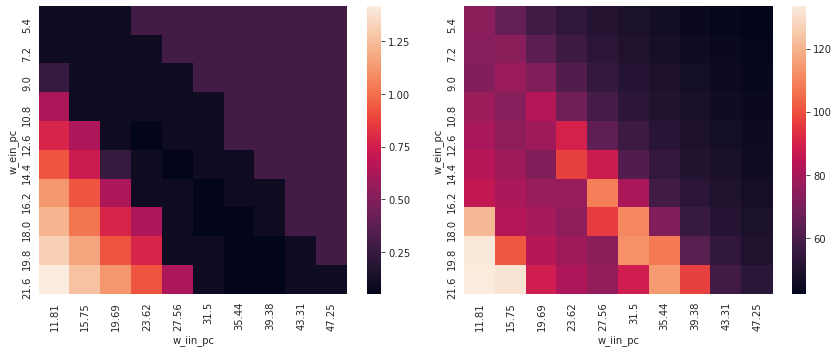

In [21]:
from pyrates.utility import plot_connectivity

# create 2D plots of maximum frequency and PSD for each parameter set
fig, axes = plt.subplots(ncols=2, figsize=(12, 5))
plot_connectivity(max_freq, yticklabels=np.round(w_ein_pc, decimals=2), 
                  xticklabels=np.round(w_iin_pc, decimals=2), ax=axes[0])
axes[0].set_ylabel('w_ein_pc')
axes[0].set_xlabel('w_iin_pc')
plot_connectivity(max_pow, yticklabels=np.round(w_ein_pc, decimals=2), 
                  xticklabels=np.round(w_iin_pc, decimals=2), ax=axes[1])
axes[1].set_ylabel('w_ein_pc')
axes[1].set_xlabel('w_iin_pc')
plt.tight_layout()

In [30]:
%matplotlib notebook

from pyrates.utility import Interactive2DParamPlot

class IPL(Interactive2DParamPlot):
    
    def get_data(self, x, y):
        return self.data[y][x]

<IPython.core.display.Javascript object>


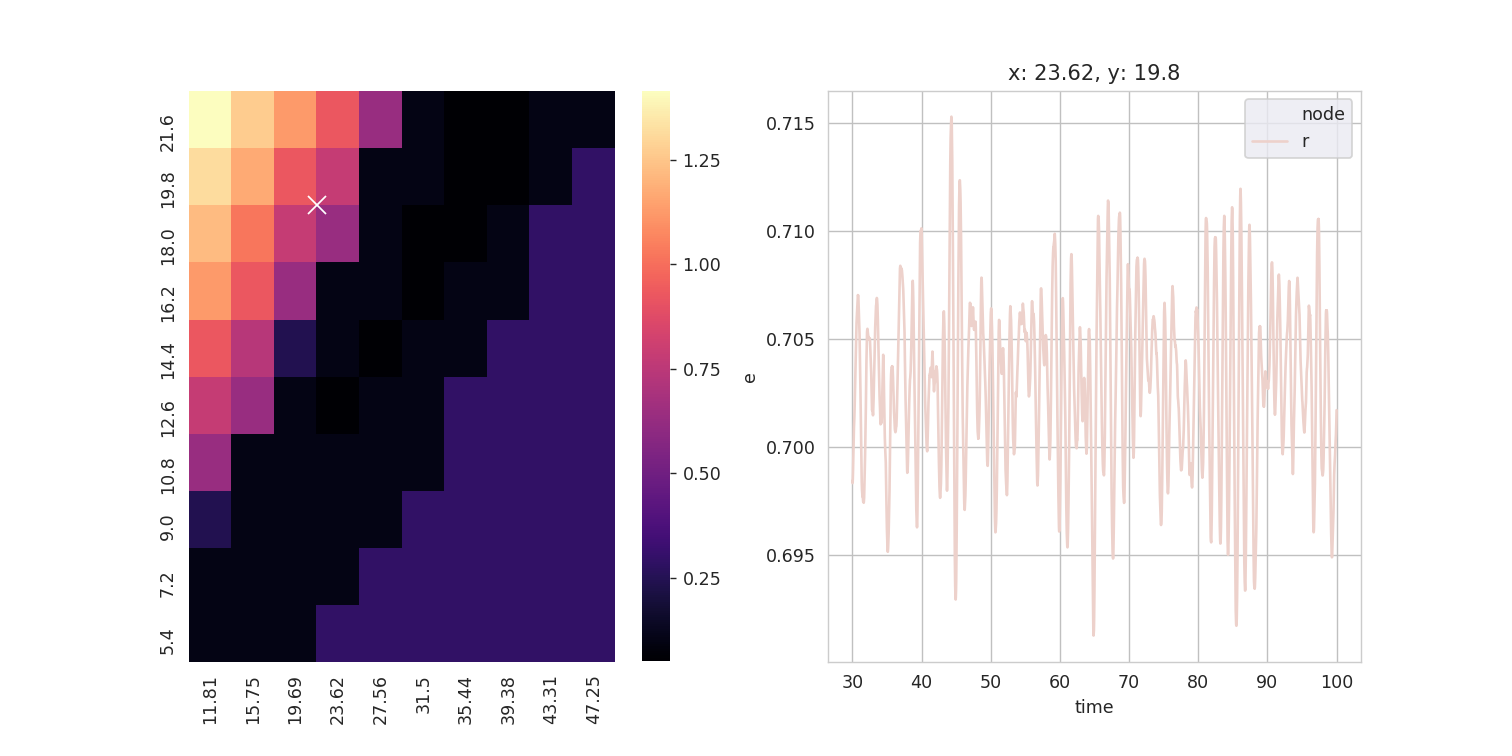

In [31]:
IPL(max_freq, results, w_iin_pc, w_ein_pc, tmin=30.0)